# Historical Aution State Classifier

### The goal:

we take 3 inputs:
From prior session (D-1)
	•	VAH₋₁
	•	VAL₋₁
	•	POC₋₁
From current session (D)
	•	Session open price
	•	Time-ordered price bars (fixed interval)



and give up 2 outputs:
   State
        balance
        attempted_breakout up
        attempted_breakout down
        discovery up
        discovery down
   Segment


we're deliberately ignoring:
	•	Developing value
	•	Volume delta
	•	VWAP
	•	Multi-day context
	•	News
	•	Volatility

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [127]:
def get_data(ticker, period, interval):
    
    #############################
    # input: ticker and interval
    # output: return
    
    ticker = yf.Ticker(str(ticker))
    data = ticker.history(period = str(period), interval = str(interval))
    return data

data = get_data(ticker = '^GSPC', period = 'max', interval = '5m') # ^GSPC is the ticker for the S&P 500

In [ ]:
# one day, if we can calculate the value area for one, we can make a function to do it for them all. 
df = data.head(78)[['High','Low']].copy()


In [131]:
df['High'] = df['High'].astype(int)
df['Low'] = df['Low'].astype(int)

In [163]:
# Get TPO for the day.
count = pd.DataFrame( columns=['count'])
for row in df.iterrows():
    for i in range(row[1]['Low'], row[1]['High']):
       count.loc[i] = count['count'].get(i, 0) + 1

#count['cumsum'] = count['count'].cumsum()
total = count['count'].sum()
POC = count[count['count']==count['count'].max()]


In [153]:
count

,count,cumsum
6766,4,4
6767,4,8
6768,4,12
6769,4,16
6770,4,20
...,...,...
6824,19,368
6825,10,378
6826,9,387
6827,7,394


In [164]:
# for each poc, we try to calculate the Value Area, and find the smallest range. 
required_count = total * 0.7
VAH = count.index[-1]
VAL = count.index[0]
for poc in POC.index:
    tempVAH = poc
    tempVAL = poc
    countsize = count.loc[poc]['count']
    while countsize < required_count:
        lower = count.loc[tempVAL-1]['count'] if tempVAL > count.index[0] else -1
        upper = count.loc[tempVAH+1]['count'] if tempVAH < count.index[-1] else -1
        # making sure we don't go out of bounds
        if countsize >= required_count: 
            break
        
        if lower > upper:
            countsize += lower
            tempVAL -= 1
        elif upper > lower:
            countsize += upper
            tempVAH += 1
        else:
            if lower != -1:
                countsize += lower
                tempVAL -= 1
            elif upper != -1:
                countsize += upper
                tempVAH += 1

    if tempVAH-tempVAL < VAH-VAL:
        VAH = tempVAH
        VAL = tempVAL

print(VAH, VAL)        



6828 6793


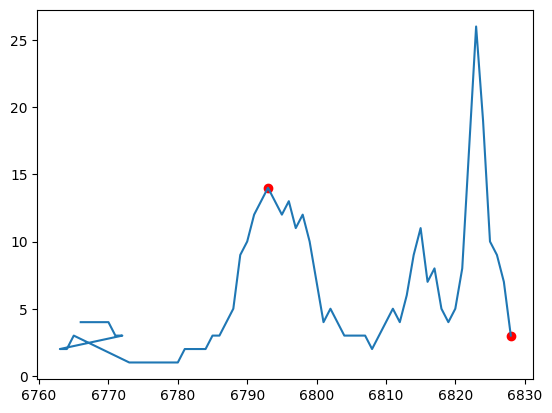

In [165]:
ax = count['count'].plot()
ax.scatter([VAL,VAH],count['count'].loc[[VAL,VAH]],color='red')

In [168]:

def getValueArea(df:pd.DataFrame):
    """
    retuns the ltp values that are at the value area low and value area high, along with the POC. 
    args:
        df: dataframe that contains 5m ohlcv data for 1 day
    returns:
    {valueLow, valuehigh, POC,POCs}
    """
    output = {}
    # book keeping
    df['High'] = df['High'].astype(int)
    df['Low'] = df['Low'].astype(int)
    
    # Get TPO for the day.
    count = pd.DataFrame( columns=['count'])
    for row in df.iterrows():
        for i in range(row[1]['Low'], row[1]['High']):
            count.loc[i] = count['count'].get(i, 0) + 1

    total = count['count'].sum()
    POC = count[count['count']==count['count'].max()]
    output['POCs'] = POC

    required_count = total * 0.7
    VAH = count.index[-1]
    VAL = count.index[0]
    for poc in POC.index:
        tempVAH = poc
        tempVAL = poc
        countsize = count.loc[poc]['count']
        while countsize < required_count:
            lower = count.loc[tempVAL-1]['count'] if tempVAL > count.index[0] else -1
            upper = count.loc[tempVAH+1]['count'] if tempVAH < count.index[-1] else -1
            # making sure we don't go out of bounds
            if countsize >= required_count: 
                break
            
            if lower > upper:
                countsize += lower
                tempVAL -= 1
            elif upper > lower:
                countsize += upper
                tempVAH += 1
            else:
                if lower != -1:
                    countsize += lower
                    tempVAL -= 1
                elif upper != -1:
                    countsize += upper
                    tempVAH += 1

        if tempVAH-tempVAL < VAH-VAL:
            output['VAH'] = tempVAH
            output['VAL'] = tempVAL
            VAH = tempVAH
            VAL = tempVAL
            output['POC'] = poc
    return output

    